In [19]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

import libpysal as lps
from esda.getisord import G_Local
from pysal.explore import esda
from pysal.lib import weights

In [49]:
# Load your LSOA shapefile
lsoa_gdf = gpd.read_file("../GIS_file/LSOA_0810.shp")
lsoa_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4969 entries, 0 to 4968
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   FID         4969 non-null   int64   
 1   lsoa11cd    4969 non-null   object  
 2   lsoa11nm    4969 non-null   object  
 3   IMDRank     4969 non-null   int64   
 4   IMDDecil    4969 non-null   int64   
 5   Shape__Are  4969 non-null   float64 
 6   Shape__Len  4969 non-null   float64 
 7   geometry    4969 non-null   geometry
dtypes: float64(2), geometry(1), int64(3), object(2)
memory usage: 310.7+ KB


In [41]:
lsoa_gdf.head(6)

,FID,lsoa11cd,lsoa11nm,IMDRank,IMDDecil,Shape__Are,Shape__Len,geometry
0,1,E01000001,City of London 001A,29199,9,343894.195702,3682.367055,"POLYGON ((532103.303 182010.987, 532160.703 18..."
1,2,E01000002,City of London 001B,30379,10,583453.103058,3910.314357,"POLYGON ((532745.016 181786.660, 532669.895 18..."
2,3,E01000003,City of London 001C,14915,5,147833.971008,1834.896718,"POLYGON ((532133.354 182197.873, 532156.459 18..."
3,4,E01000005,City of London 001E,8678,3,491901.220234,3483.118352,"POLYGON ((533806.141 180767.574, 533647.261 18..."
4,5,E01000006,Barking and Dagenham 016A,14486,5,372254.489704,3108.596473,"POLYGON ((545120.187 184314.762, 545270.053 18..."
5,6,E01000007,Barking and Dagenham 015A,7256,3,511537.659718,4537.652099,"POLYGON ((544178.491 184700.415, 544315.337 18..."


In [5]:
points_data = gpd.read_file('../GIS_file/end_points0.geojson')
points_data.head(2)

,EndStation Id,inbound_counts,id,name,lat,lon,capacity,geometry
0,39,767,39,"Shoreditch High Street, Shoreditch",51.526378,-0.078131,3,POINT (533420.107 182579.821)
1,53,74,53,"Grafton Street, Mayfair",51.509992,-0.143495,2,POINT (528932.257 180640.623)


In [50]:
# 空间连接
joined_data = gpd.sjoin(points_data, lsoa_gdf, how="inner", predicate="within")

# 分组并计算每个 LSOA 单元内 'outbound_counts' 的总和
summed_data = joined_data.groupby('lsoa11cd')['inbound_counts'].sum()

# 将结果添加到 lsoa_gdf 中
lsoa_gdf = lsoa_gdf.set_index('lsoa11cd')
lsoa_gdf['total_inbound_counts'] = summed_data

In [51]:
lsoa_gdf.head()

,FID,lsoa11nm,IMDRank,IMDDecil,Shape__Are,Shape__Len,geometry,total_inbound_counts
lsoa11cd,,,,,,,,
E01000001,1,City of London 001A,29199,9,343894.195702,3682.367055,"POLYGON ((532103.303 182010.987, 532160.703 18...",NaN
E01000002,2,City of London 001B,30379,10,583453.103058,3910.314357,"POLYGON ((532745.016 181786.660, 532669.895 18...",80.0
E01000003,3,City of London 001C,14915,5,147833.971008,1834.896718,"POLYGON ((532133.354 182197.873, 532156.459 18...",NaN
E01000005,4,City of London 001E,8678,3,491901.220234,3483.118352,"POLYGON ((533806.141 180767.574, 533647.261 18...",65.0
E01000006,5,Barking and Dagenham 016A,14486,5,372254.489704,3108.596473,"POLYGON ((545120.187 184314.762, 545270.053 18...",NaN


In [35]:
lsoa_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 4969 entries, E01000001 to E01033030
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   FID                   4969 non-null   int64   
 1   lsoa11nm              4969 non-null   object  
 2   IMDRank               4969 non-null   int64   
 3   IMDDecil              4969 non-null   int64   
 4   Shape__Are            4969 non-null   float64 
 5   Shape__Len            4969 non-null   float64 
 6   geometry              4969 non-null   geometry
 7   total_inbound_counts  299 non-null    float64 
 8   moran_loc             0 non-null      float64 
dtypes: float64(4), geometry(1), int64(3), object(1)
memory usage: 517.2+ KB


Original CRS of london_boundary.shp: epsg:27700
Converted CRS of london_boundary.shp: epsg:27700


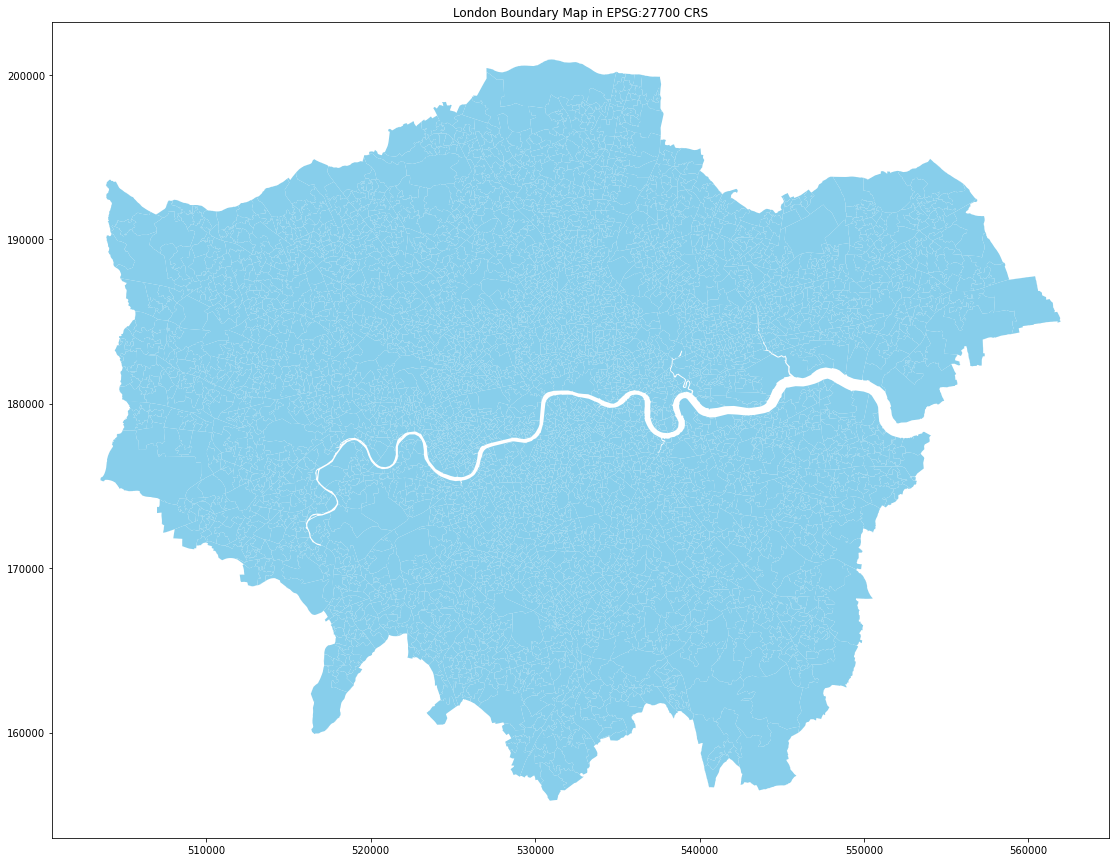

In [52]:
# Check the original coordinate reference system
print(f"Original CRS of london_boundary.shp: {lsoa_gdf.crs}")

# Convert the CRS to EPSG:27700
lsoa_gdf_27700 = lsoa_gdf.to_crs(epsg=27700)

# Check the new coordinate reference system
print(f"Converted CRS of london_boundary.shp: {lsoa_gdf_27700.crs}")

# Create a plot
fig, ax = plt.subplots(figsize=(20, 15))

# Plot the converted LSOA shapefile
lsoa_gdf_27700.plot(ax=ax, color='skyblue', edgecolor='none', legend=True)

# Plot the converted LSOA shapefile based on population density
#lsoa_gdf_27700.plot(ax=ax, column='IMDRank', cmap='viridis', edgecolor='none', legend=True)

# Add title
ax.set_title('London Boundary Map in EPSG:27700 CRS')

# Show plot
plt.show()

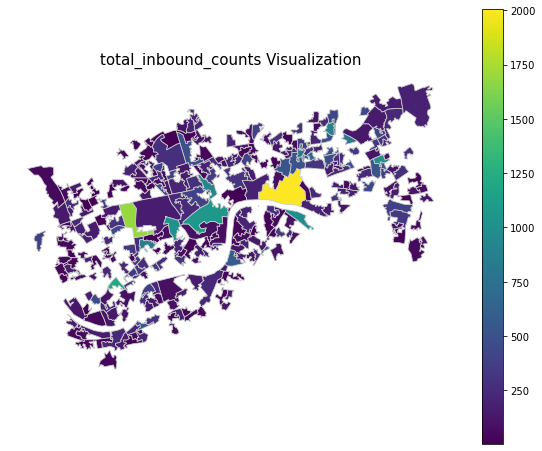

In [53]:
# Plot the GeoDataFrame with color mapping
fig, ax = plt.subplots(figsize=(10, 8))
lsoa_gdf.plot(column='total_inbound_counts', cmap='viridis', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

# Customize the plot
ax.set_title('total_inbound_counts Visualization', fontdict={'fontsize': '15', 'fontweight': '3'})
ax.set_axis_off()

# Show the plot
plt.show()

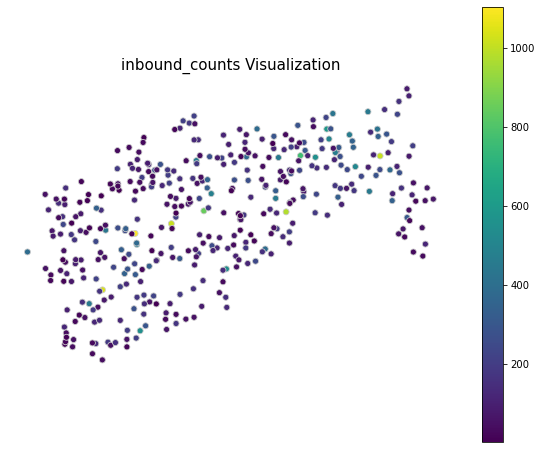

In [13]:
# Plot the GeoDataFrame with color mapping
fig, ax = plt.subplots(figsize=(10, 8))
points_data.plot(column='inbound_counts', cmap='viridis', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

# Customize the plot
ax.set_title('inbound_counts Visualization', fontdict={'fontsize': '15', 'fontweight': '3'})
ax.set_axis_off()

# Show the plot
plt.show()

In [36]:
lsoa_gdf.head()

,FID,lsoa11nm,IMDRank,IMDDecil,Shape__Are,Shape__Len,geometry,total_inbound_counts,moran_loc
lsoa11cd,,,,,,,,,
E01000001,1,City of London 001A,29199,9,343894.195702,3682.367055,"POLYGON ((532103.303 182010.987, 532160.703 18...",NaN,NaN
E01000002,2,City of London 001B,30379,10,583453.103058,3910.314357,"POLYGON ((532745.016 181786.660, 532669.895 18...",80.0,NaN
E01000003,3,City of London 001C,14915,5,147833.971008,1834.896718,"POLYGON ((532133.354 182197.873, 532156.459 18...",NaN,NaN
E01000005,4,City of London 001E,8678,3,491901.220234,3483.118352,"POLYGON ((533806.141 180767.574, 533647.261 18...",65.0,NaN
E01000006,5,Barking and Dagenham 016A,14486,5,372254.489704,3108.596473,"POLYGON ((545120.187 184314.762, 545270.053 18...",NaN,NaN


In [38]:
lsoa_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 4969 entries, E01000001 to E01033030
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   FID                   4969 non-null   int64   
 1   lsoa11nm              4969 non-null   object  
 2   IMDRank               4969 non-null   int64   
 3   IMDDecil              4969 non-null   int64   
 4   Shape__Are            4969 non-null   float64 
 5   Shape__Len            4969 non-null   float64 
 6   geometry              4969 non-null   geometry
 7   total_inbound_counts  4969 non-null   float64 
 8   moran_loc             0 non-null      float64 
dtypes: float64(4), geometry(1), int64(3), object(1)
memory usage: 517.2+ KB


In [37]:
# 查看 total_inbound_counts 列的空值数量
null_count = lsoa_gdf['total_inbound_counts'].isnull().sum()

# 将空值赋值为0
lsoa_gdf['total_inbound_counts'].fillna(0, inplace=True)

# 打印空值数量
print(f'总共有 {null_count} 个空值已被赋值为0')

总共有 4670 个空值已被赋值为0


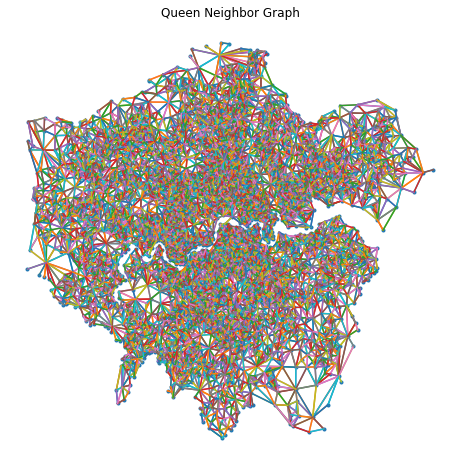

In [30]:
'''
# Create a weights matrix
wq = lps.weights.Queen.from_dataframe(lsoa_gdf)
wq.transform = 'r'

centroids = lsoa_gdf.geometry.centroid

# 创建一个 Figure 对象
fig, ax = plt.subplots(figsize=(8, 8))

# 绘制点和线
plt.plot(centroids.x, centroids.y, '.')
for k, neighs in wq.neighbors.items():
    origin = centroids[k]
    for neigh in neighs:
        segment = centroids[[k, neigh]]
        plt.plot(segment.x, segment.y, '-')

plt.title('Queen Neighbor Graph')
plt.axis('off')
plt.show()
'''

In [34]:
y=points_data["inbound_counts"]
mi = esda.moran.Moran(y, wq)

print("Moran's I 值为：",mi.I)
print("随机分布假设下Z检验值为：",mi.z_rand)
print("随机分布假设下Z检验的P值为：",mi.p_rand)
print("正态分布假设下Z检验值为：",mi.z_norm)
print("正态分布假设下Z检验的P值为：",mi.p_norm)

Moran's I 值为： nan
随机分布假设下Z检验值为： nan
随机分布假设下Z检验的P值为： nan
正态分布假设下Z检验值为： nan
正态分布假设下Z检验的P值为： nan


In [ ]:
from splot.esda import plot_moran

plot_moran(mi, zstandard=True, figsize=(10,4))
plt.show()


In [ ]:
# Create a plot
fig, ax = plt.subplots(figsize=(12, 8))
#fig, ax = plt.plots(figsize=(12, 8))
# Plot the service area
#lsoa_gdf_27700.plot(ax=ax, color='lightgrey', edgecolor='none')

# Plot the station points with size based on log-scaled "inbike_locationsbound_counts"
end_points0.plot(ax=ax, color='yellow', markersize=end_points0['inbound_counts'] / 10, edgecolor='darkgoldenrod', alpha=0.7)

# Add title
ax.set_title('Santander bike trip origin points in London -cluster 0 (EPSG:27700)')

# Show plot
plt.show()

In [ ]:
# Create a plot
fig, ax = plt.subplots(figsize=(12, 8))
#fig, ax = plt.plots(figsize=(12, 8))
# Plot the service area
#lsoa_gdf_27700.plot(ax=ax, color='lightgrey', edgecolor='none')

# Plot the station points with size based on log-scaled "inbike_locationsbound_counts"
end_points1.plot(ax=ax, color='yellow', markersize=end_points1['inbound_counts'] / 10, edgecolor='darkgoldenrod', alpha=0.7)

# Add title
ax.set_title('Santander bike trip origin points in London -cluster 1 (EPSG:27700)')

# Show plot
plt.show()

In [ ]:


# Load your spatial data with weighted incident points
# Replace 'your_data.shp' with the path to your shapefile
gdf = gpd.read_file('your_data.shp')

# Replace 'your_weight_field' with the name of the field containing weights
weights = gdf['your_weight_field'].values

# Specify the column name that you want to analyze
attribute_to_analyze = 'your_attribute_to_analyze'

# Create a spatial weights matrix
w = lps.weights.KNN.from_dataframe(gdf, k=5)

# Perform Local Getis-Ord Gi* analysis
lisa = G_Local(gdf[attribute_to_analyze], w, permutations=999)

# Extract results
significant_hotspots = gdf[lisa.p_sim < 0.05]  # Change the significance level if needed
significant_coldspots = gdf[lisa.p_sim < 0.05]

# Print or visualize the results as needed
print("Significant Hotspots:")
print(significant_hotspots)

print("Significant Coldspots:")
print(significant_coldspots)
